# PROJECT STATEMENT
# ***PREDICT USER-DEFINED STOCK'S PRICE FOR THE NEXT DAY, WEEK, OR MONTH***

---

- We will use yfinance library to download stock data.
- However, the user will be unsure regarding the stock symbol, as yahoo finance includes extensions for stock symbol for exchanges outside USA territory.
- Hence, we will implement a module that will scrape suggestions for the search box on finance.yahoo.com and present it to the user. The suggestion include ticker symbol, company name, and the stock exchange it belongs to.
- Then, user can use the correct ticker symbol with another module which extracts historical stock data using yfinance
- To avoid blocking from yahoo finance, we will use code from yfinance's github page to implement a rate-limiting and request caching session system.
- Once the data is acquired, we will be able to plot it.
- We also want to consider other indicators to include with the stock data that will help us with forecasting stock price

---

## SCRAPING STOCK DATA

### Code to extract symbol suggestions from search bar in yahoo finance

In [15]:
# Importing necessary libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup
import re
import pandas as pd
import time

def search_symbols(search_str):
    # Input: search string
    # Output: No result found message or data frame of possible suggestions
    # Function to return data frame of suggestions appearing in yahoo finance website's search bar on entering a string

    start_time = time.time() # Tracking time when this function started running

    # Creating options object and setting preferences
    options=Options()
    options.set_preference("permissions.default.image", 2) # To limit image loading
    options.set_preference("permissions.default.video", 2) # To limit videos loading
    options.set_preference("media.autoplay.default", 1) # To limit autoplay media loading
    options.set_preference("media.autoplay.enabled.user-gestures-needed", False) # To stop autoplay of media
    options.add_argument("-headless") # Running browser in headless mode
    
    driver = webdriver.Firefox(options=options) # Launching Firefox browser with preferred options
    
    url = "https://finance.yahoo.com/" # URL of yahoo finance website
    
    driver.get(url) # Launching URL

    # Find search box and enter search string
    driver.find_element(By.ID, "yfin-usr-qry").send_keys(search_str)

    # Creating an explicit wait object to wait for 5 seconds
    wait = WebDriverWait(driver, 5)

    # Try for presense of 'Symbols' tab in search results and quit if explicit wait runs out and exit function
    # This is for cases where the search string has no symbol results
    try:
        sym = wait.until(EC.presence_of_element_located((By.XPATH, "//h3[contains(text(), 'Symbols')]")))
    except:
        driver.quit() # Quit driver
        print(f"This operation took {time.time() - start_time} seconds") # Print amount of time since start of function
        return "No relevant stocks found." # Return message that no stocks were found
    
    # Getting symbol data results by traversing XPATH
    sym_list = sym.find_element(By.XPATH, "../following-sibling::*[1]")

    # Extracting symbol data into soup
    soup = BeautifulSoup(sym_list.get_attribute("innerHTML"), "html.parser")
    
    driver.quit() # Quit driver as we've acquired soup

    items = soup.find_all('li') # Find every list item in symbols suggestion list

    # Creating lists for symbol, company name, and exchange
    symbol_list = []
    company_name_list = []
    exchange_list = []

    # Extracting symbol, company name, and exchange 
    for item in items:
        symbol = item.find('div', class_=re.compile(r'modules_quoteSymbol.*')).text.strip() # Extract Symbol
        # If stock is not publicly listed, it shows the symbol as private, in which case we ignore it
        if symbol == 'PRIVATE':
            continue
        symbol_list.append(symbol) # Add symbol to symbol list
        company_name = item.find('div', class_=re.compile(r'modules_quoteCompanyName.*')).text.strip() # Extract company name
        company_name_list.append(company_name) # Add company name to company name list
        exchange_name = item.find('span', class_=re.compile(r'modules_quoteSpan.*')).text.strip().split(' - ')[1] # Extract exchange
        exchange_list.append(exchange_name) # Add exchange name to exchange name list

    # Create a dataframe for the symbols, company names, and exchanges
    possible_symbols = pd.DataFrame({'Symbol':symbol_list, 'Company':company_name_list, 'Exchange':exchange_list})

    # If a company name is suggested by not listed (i.e. it is private), an empty data frame will be created
    # If an empty dataframe is created, we print the time taken by the function and return a message that no stocks were found
    if possible_symbols.shape[0] == 0:
        print(f"This operation took {time.time() - start_time} seconds")
        return "No relevant stocks found."
    # If dataframe is generated, print time taken by the function and return dataframe
    print(f"Getting these suggestions took {time.time() - start_time} seconds")
    return possible_symbols

In [16]:
# Get stock suggestions for string 'apple'
print(search_symbols('apple'))

    Symbol                       Company Exchange
0     AAPL                    Apple Inc.      NMS
1     APLE  Apple Hospitality REIT, Inc.      NYQ
2  AAPL.NE                    Apple Inc.      NEO
3    APC.F                    Apple Inc.      FRA
4  AAPL.MX                    Apple Inc.      MEX
Getting these suggestions took 31.94590139389038 seconds


In [17]:
# Get stock suggestions for string 'reliance'
print(search_symbols('reliance'))

        Symbol                          Company Exchange
0  RELIANCE.NS      Reliance Industries Limited      NSI
1           RS    Reliance Steel & Aluminum Co.      NYQ
2         RELI      Reliance Global Group, Inc.      NCM
3  RELINFRA.NS  Reliance Infrastructure Limited      NSI
4    RPOWER.NS           Reliance Power Limited      NSI
Getting these suggestions took 39.61316752433777 seconds


In [18]:
# Get stock suggestions for string 'byju'
print(search_symbols('byju'))

No relevant stocks found.
Getting these suggestions took 40.2602002620697 seconds


### Code to extract historical stock data 

In [1]:
import os, sys

import pandas as pd
from plotly import graph_objs as go

import yfinance as yf

from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

# CachedLimiterSession class extends the CacheMixin, LimiterMixin, and Session classes.
# This class combines request caching (SQLiteCache) and rate limiting (Limiter) functionalities to prevent excessive API requests.
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

# An instance of CachedLimiterSession is created as session with a rate limit of 2 requests per 5 seconds and a caching backend using SQLite.
session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache")
    )

# suppresses the output to the standard output stream (stdout). 
# This class is used to silence the printing of unwanted information during the execution of the script.
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def plot_stock_data(stock, hist):
    # Input: yfinance stock ticker, dataframe of historical data
    # Provides interactive plot of the Open and Close stock prices

    # Create a plotly figure graphical object
    fig = go.Figure()
    # Add Scatter plots for Open and Close prices
    fig.add_trace(go.Scatter(x=hist.index, y=hist.Open, name="Stock Open"))
    fig.add_trace(go.Scatter(x=hist.index, y=hist.Close, name="Stock Close"))
    # Plotting Stock name as plot title (from stock ticker) with range slider for time
    fig.layout.update(title_text=f"{stock.info['longName']} Stock Price", width = 1150, height = 600, xaxis_rangeslider_visible=True)
    # Show plot
    fig.show()

In [3]:
# Loop to take ticker symbol from user and plot the Open and Close prices
# Enter quit to exit loop
while(True):
    symbol = input("Enter the stock symbol here: (Enter quit to exit)")
    # Break loop if 'quit' is entered
    if symbol.lower() == 'quit':
        break
    # Create a yfinance ticker object for user-defined symbol and using a session for rate-limiting and request caching
    stock = yf.Ticker(symbol, session=session)
    # If symbol is invalid, yfinance prints a long message regarding unavailability of the data and possible reasons, and returns an empty dataframe
    # To supress this message, we use HiddenPrints class
    with HiddenPrints():
        # Get entire available stock data using yfinance for user-defined symbol
        hist = stock.history(period="max")
    # If dataframe is empty, we print a message regarding unavailability of data, and loop again
    if hist.shape[0] == 0:
        print("No data found. Symbol is not listed.")
        continue
    # If historical data is retrieved, we plot it
    plot_stock_data(stock, hist)

Enter the stock symbol here: (Enter quit to exit) reliance.ns


Enter the stock symbol here: (Enter quit to exit) exit


No data found. Symbol is not listed.


Enter the stock symbol here: (Enter quit to exit) quit


In [3]:
# Code to get a dataframe of the historical stock data
# Take ticker symbol from user
symbol = input("Enter the stock symbol here: (Enter quit to exit)")
# Create a yfinance ticker object for user-defined symbol and using a session for rate-limiting and request caching
stock = yf.Ticker(symbol, session=session)
# If symbol is invalid, yfinance prints a long message regarding unavailability of the data and possible reasons, and returns an empty dataframe
# To supress this message, we use HiddenPrints class
with HiddenPrints():
    # Get entire available stock data using yfinance for user-defined symbol
    hist = stock.history(period="max")
# If dataframe is empty, we print a message regarding unavailability of data
if hist.shape[0] == 0:
    print("No data found. Symbol is not listed.")
# Dropping Dividends and Stock Splits columns as Dividends are very rare and price changes after Stock Splits are accounted for in yahoo finance
hist.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)
# If historical data is retrieved, we print the dataframe
hist

Enter the stock symbol here: (Enter quit to exit) reliance.ns


Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439798    10.495816    10.371047    10.477992  \
1996-01-02 00:00:00+05:30    10.452527    10.503453    10.320120    10.396509   
1996-01-03 00:00:00+05:30    10.567113    11.048363    10.452530    10.475447   
1996-01-04 00:00:00+05:30    10.376141    10.409243    10.238641    10.378687   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-09 00:00:00+05:30  2507.000000  2508.550049  2478.000000  2481.949951   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   

                              Volume  
Date                                  
1996-01-01 00:00:00+05:30   48051995  
1996-01-02 00:00:00+05:30   77875009  
1996-01-03 00:00:00+05:30   96602936  
1996-01-04 00:00:00+05:30  100099436  
1996-01-05 00:00:00+05:30   76935930  
...                              ...  
2023-06-09 00:00:00+05:30    2712243  
2023-06-12 00:00:00+05:30    2949893  
2023-06-13 00:00:00+05:30    5190958  
2023-06-14 00:00:00+05:30    6127509  
2023-06-15 00:00:00+05:30    5450893  

[6902 rows x 5 columns]

---
## FINDING OTHER INDICATORS

### 1. Relative Strength Index (RSI)

The RSI is a momentum oscillator that measures the speed and change of price movements. It compares the magnitude of recent gains to recent losses over a specified period of time. The period determines the number of historical data points considered in the calculation.

The RSI calculation involves calculating the average gains and losses, calculating the relative strength (RS = Avg Gains / Avg Losses), and then deriving the RSI using the formula: RSI = 100 - (100 / (1 + RS)).

RS values can range between 0 to infinity. 
- When a window has mostly gains, we have very large RS value
- When a window has mostly losses, we have very small RS value close to 0
- When a window has around the same amount of gains and losses, we have an RS value of 1

RSI values can range between 0 to 100.
- high gains, very large RS value, RSI value slightly smaller than 100
- high losses, very small RS value, RSI value close to 0
- same gains and losses, RS value 1, RSI value nearly half i.e. 50

So, average gain to loss ratio is stretched or squeezed to be between 0 and 100.

In [4]:
def calculate_rsi(data, window=14):
    # Input: stock data, window
    # output: RSI
    # Function to calculate RSI using historical closing prices of a stock
    close_delta = data['Close'].diff()
    up = close_delta.where(close_delta > 0, 0)
    down = -close_delta.where(close_delta < 0, 0)

    # Calculate the average gains and losses
    avg_gain = up.rolling(window).mean()
    avg_loss = down.rolling(window).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Calculate RSI using the close price and a window of 14 periods
hist['rsi'] = calculate_rsi(hist)

# Print dataframe
hist

Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439798    10.495816    10.371047    10.477992  \
1996-01-02 00:00:00+05:30    10.452527    10.503453    10.320120    10.396509   
1996-01-03 00:00:00+05:30    10.567113    11.048363    10.452530    10.475447   
1996-01-04 00:00:00+05:30    10.376141    10.409243    10.238641    10.378687   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-09 00:00:00+05:30  2507.000000  2508.550049  2478.000000  2481.949951   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   

                              Volume        rsi  
Date                                             
1996-01-01 00:00:00+05:30   48051995        NaN  
1996-01-02 00:00:00+05:30   77875009        NaN  
1996-01-03 00:00:00+05:30   96602936        NaN  
1996-01-04 00:00:00+05:30  100099436        NaN  
1996-01-05 00:00:00+05:30   76935930        NaN  
...                              ...        ...  
2023-06-09 00:00:00+05:30    2712243  56.035817  
2023-06-12 00:00:00+05:30    2949893  56.577738  
2023-06-13 00:00:00+05:30    5190958  66.289404  
2023-06-14 00:00:00+05:30    6127509  70.118664  
2023-06-15 00:00:00+05:30    5450893  60.848056  

[6902 rows x 6 columns]

### 2. Moving Average Convergence Divergence (MACD)

The Moving Average Convergence Divergence (MACD) is a popular technical analysis indicator used to identify potential trend reversals, generate buy and sell signals, and gauge the strength of price movements. It consists of three main components: the MACD line, the signal line, and the histogram.

    MACD Line: The MACD line is calculated by subtracting the longer-term exponential moving average (EMA) from the shorter-term EMA. The most common settings for these EMAs are 26 and 12 periods, respectively, although they can be adjusted based on individual preferences or trading strategies. The MACD line represents the difference between these two EMAs and is used to capture the momentum of price changes.

    Signal Line: The signal line is a moving average (often a 9-period EMA) of the MACD line. It helps smooth out the MACD line and generate trading signals. When the MACD line crosses above the signal line, it is considered a bullish signal, indicating a potential buying opportunity. Conversely, when the MACD line crosses below the signal line, it is seen as a bearish signal, suggesting a potential selling opportunity.

    Histogram: The histogram is derived from the MACD line and the signal line. It represents the difference between the MACD line and the signal line and provides a visual representation of the convergence and divergence of the two lines. When the histogram bars are positive, it suggests upward momentum, and when they are negative, it indicates downward momentum. The height of the bars reflects the strength of the price movement.

By analyzing the MACD line, signal line, and histogram, traders can interpret the indicator to make trading decisions. For example, when the MACD line crosses above the signal line and the histogram bars turn positive, it may be considered a signal to buy. Conversely, when the MACD line crosses below the signal line and the histogram bars turn negative, it may be seen as a signal to sell.

It's worth noting that the MACD is a lagging indicator, meaning it may not provide timely signals during volatile market conditions or rapid price changes. Therefore, it is often used in conjunction with other indicators or tools to confirm trading decisions.decisions.

In [5]:
# Define a function to calculate MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # Calculate the short-term EMA
    ema_short = data['Close'].ewm(span=short_period, adjust=False).mean()

    # Calculate the long-term EMA
    ema_long = data['Close'].ewm(span=long_period, adjust=False).mean()

    # Calculate the MACD line
    macd_line = ema_short - ema_long

    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line

    return macd_histogram

hist['macd'] = calculate_macd(hist)

In [6]:
hist

Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439798    10.495816    10.371047    10.477992  \
1996-01-02 00:00:00+05:30    10.452527    10.503453    10.320120    10.396509   
1996-01-03 00:00:00+05:30    10.567113    11.048363    10.452530    10.475447   
1996-01-04 00:00:00+05:30    10.376141    10.409243    10.238641    10.378687   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-09 00:00:00+05:30  2507.000000  2508.550049  2478.000000  2481.949951   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   

                              Volume        rsi  macd_line  signal_line   
Date                                                                      
1996-01-01 00:00:00+05:30   48051995        NaN   0.000000     0.000000  \
1996-01-02 00:00:00+05:30   77875009        NaN  -0.006500    -0.001300   
1996-01-03 00:00:00+05:30   96602936        NaN  -0.005222    -0.002084   
1996-01-04 00:00:00+05:30  100099436        NaN  -0.011879    -0.004043   
1996-01-05 00:00:00+05:30   76935930        NaN  -0.022647    -0.007764   
...                              ...        ...        ...          ...   
2023-06-09 00:00:00+05:30    2712243  56.035817  18.901733    21.456609   
2023-06-12 00:00:00+05:30    2949893  56.577738  17.832303    20.731748   
2023-06-13 00:00:00+05:30    5190958  66.289404  19.718864    20.529171   
2023-06-14 00:00:00+05:30    6127509  70.118664  23.445158    21.112368   
2023-06-15 00:00:00+05:30    5450893  60.848056  26.153273    22.120549   

                           macd_histogram  
Date                                       
1996-01-01 00:00:00+05:30        0.000000  
1996-01-02 00:00:00+05:30       -0.005200  
1996-01-03 00:00:00+05:30       -0.003137  
1996-01-04 00:00:00+05:30       -0.007836  
1996-01-05 00:00:00+05:30       -0.014883  
...                                   ...  
2023-06-09 00:00:00+05:30       -2.554876  
2023-06-12 00:00:00+05:30       -2.899445  
2023-06-13 00:00:00+05:30       -0.810307  
2023-06-14 00:00:00+05:30        2.332789  
2023-06-15 00:00:00+05:30        4.032724  

[6902 rows x 9 columns]

### 3. Volatility

Volatility: Gives standard deviation of the rolling window. Indicates faith of the market in the stocks trend.e market.

In [7]:
def calculate_std(data, window=20):
    # Calculate the rolling standard deviation
    rolling_std = data['Close'].rolling(window=window).std()
    
    return rolling_std

# Calculate Volatility
hist['volatility'] = calculate_std(hist)

### 4. Inflation

Inflation can have both direct and indirect effects on stock prices. Here are a few ways in which inflation can impact stock prices:

    Purchasing Power: Inflation erodes the purchasing power of money over time. As the general price level rises, the value of each unit of currency decreases. This can lead to a decrease in consumer spending and corporate profits, which can ultimately affect stock prices negatively.

    Interest Rates: Central banks often respond to inflation by raising interest rates to curb rising prices. Higher interest rates can increase borrowing costs for businesses, making it more expensive for them to invest and expand. This can dampen corporate earnings and decrease stock prices.

    Investor Sentiment: Inflation can affect investor sentiment and confidence in the market. Uncertainty about future inflation rates can lead to volatility and fluctuations in stock prices. Investors may become cautious or seek inflation-hedging assets, which can impact the demand and supply of stocks.

    Industry and Sector Performance: Inflation can impact different industries and sectors differently. Some sectors, such as utilities and consumer staples, are often considered defensive during inflationary periods because they provide essential goods and services. On the other hand, industries like technology and discretionary consumer goods may be more sensitive to inflation due to higher input costs. As a result, the performance of different sectors during inflationary periods can affect the overall stock market.

    Valuation Metrics: Inflation can impact the valuation of stocks. Higher inflation may lead to higher discount rates used to value future cash flows, resulting in lower stock valuations. Moreover, rising inflation can also increase the cost of goods and services, potentially reducing profit margins and affecting price-to-earnings ratios.

It's important to note that the relationship between inflation and stock prices is complex and can be influenced by various factors such as economic conditions, monetary policy, investor expectations, and market sentiment. Additionally, different companies and sectors may be affected differently by inflation. Therefore, understanding the specific dynamics of the market and conducting thorough analysis is crucial to assess the potential impact of inflation on stock prices.

In [8]:
import wbdata

# Importing a data frame created from scraped stock data from 2017 from finance.yahoo.com
# It contains exchanges and their countries
exc_country_df = pd.read_csv('exchanges_by_country.csv')

# Importing a data frame created using countries and their codes from World bank's website
countries = pd.read_csv("country_codes.csv")

# Extracting country from exc_country_df by matching to stock's exchange
stock_country = exc_country_df[exc_country_df.exchange == stock.info['exchange']].country.values[0]

# Extracting country code from countries data frame by matching to the stock's country
stock_country_code = countries[countries.Country == stock_country].Code.values[0]

# Getting historical inflation data from wbdata library using the extracted country code
stock_country_inflation_data = wbdata.get_dataframe(indicators={'FP.CPI.TOTL.ZG':'Inflation'}, 
                                                    country=stock_country_code, 
                                                    freq = 'M', 
                                                    convert_date = True)

# Extract year from the index of stock_country_inflation_data
stock_country_inflation_data['year'] = stock_country_inflation_data.index.year

# Extract year from the index of hist
hist['year'] = hist.index.year

# Merge the two data frames based on the year
temp_df = pd.merge(hist, stock_country_inflation_data, how='left', on='year')
# Setting index on hist to the new dataframe
temp_df.index = hist.index
# Assigning new dataframe to hist
hist = temp_df
# Drop the unnecessary columns
hist.drop(['year'], axis=1, inplace=True)

In [9]:
hist

Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439798    10.495816    10.371047    10.477992  \
1996-01-02 00:00:00+05:30    10.452527    10.503453    10.320120    10.396509   
1996-01-03 00:00:00+05:30    10.567113    11.048363    10.452530    10.475447   
1996-01-04 00:00:00+05:30    10.376141    10.409243    10.238641    10.378687   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-09 00:00:00+05:30  2507.000000  2508.550049  2478.000000  2481.949951   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   

                              Volume        rsi  macd_line  signal_line   
Date                                                                      
1996-01-01 00:00:00+05:30   48051995        NaN   0.000000     0.000000  \
1996-01-02 00:00:00+05:30   77875009        NaN  -0.006500    -0.001300   
1996-01-03 00:00:00+05:30   96602936        NaN  -0.005222    -0.002084   
1996-01-04 00:00:00+05:30  100099436        NaN  -0.011879    -0.004043   
1996-01-05 00:00:00+05:30   76935930        NaN  -0.022647    -0.007764   
...                              ...        ...        ...          ...   
2023-06-09 00:00:00+05:30    2712243  56.035817  18.901733    21.456609   
2023-06-12 00:00:00+05:30    2949893  56.577738  17.832303    20.731748   
2023-06-13 00:00:00+05:30    5190958  66.289404  19.718864    20.529171   
2023-06-14 00:00:00+05:30    6127509  70.118664  23.445158    21.112368   
2023-06-15 00:00:00+05:30    5450893  60.848056  26.153273    22.120549   

                           macd_histogram   
Date                                        
1996-01-01 00:00:00+05:30        0.000000  \
1996-01-02 00:00:00+05:30       -0.005200   
1996-01-03 00:00:00+05:30       -0.003137   
1996-01-04 00:00:00+05:30       -0.007836   
1996-01-05 00:00:00+05:30       -0.014883   
...                                   ...   
2023-06-09 00:00:00+05:30       -2.554876   
2023-06-12 00:00:00+05:30       -2.899445   
2023-06-13 00:00:00+05:30       -0.810307   
2023-06-14 00:00:00+05:30        2.332789   
2023-06-15 00:00:00+05:30        4.032724   

                           bollinger_rolling_mean_or_simple_moving_average   
Date                                                                         
1996-01-01 00:00:00+05:30                                              NaN  \
1996-01-02 00:00:00+05:30                                              NaN   
1996-01-03 00:00:00+05:30                                              NaN   
1996-01-04 00:00:00+05:30                                              NaN   
1996-01-05 00:00:00+05:30                                              NaN   
...                                                                    ...   
2023-06-09 00:00:00+05:30                                      2470.992493   
2023-06-12 00:00:00+05:30                                      2470.737488   
2023-06-13 00:00:00+05:30                                      2474.089990   
2023-06-14 00:00:00+05:30                                      2479.717493   
2023-06-15 00:00:00+05:30                                      2485.642493   

                           standard_deviation_or_volatility   
Date                                                          
1996-01-01 00:00:00+05:30                               NaN  \
1996-01-02 00:00:00+05:30                               NaN   
1996-01-03 00:00:00+05:30                               NaN   
1996-01-04 00:00:00+05:30                               NaN   
1996-01-05 00:00:00+05:30

### 5. Lending interest rate (%)

The lending interest rate can indirectly influence stock price forecasting through its impact on the overall economic conditions and investor behavior. Here are a few ways in which the lending interest rate can potentially affect stock price forecasting:

    Cost of Capital: The lending interest rate affects the cost of capital for companies. When the lending interest rate is low, borrowing becomes cheaper, which can stimulate business expansion, investment, and overall economic growth. This can positively impact company earnings and potentially lead to higher stock prices. Conversely, higher lending interest rates can increase borrowing costs for companies, potentially dampening their profitability and impacting stock prices negatively.

    Investor Sentiment: Changes in lending interest rates can influence investor sentiment and risk appetite. When lending rates are low, investors may be more inclined to borrow money for investments, including stocks, as the cost of borrowing is relatively lower. This increased demand for stocks can potentially drive up stock prices. Conversely, higher lending rates can make borrowing for investment purposes less attractive, potentially leading to reduced demand for stocks and lower prices.

    Discount Rate: The lending interest rate can impact the discount rate used in discounted cash flow (DCF) analysis, a commonly used valuation method for stocks. The discount rate is used to determine the present value of future cash flows, and it typically incorporates the risk-free rate (such as government bond yields) plus a risk premium. If the lending interest rate increases, it may lead to higher risk-free rates and, consequently, a higher discount rate. This can result in a lower present value of future cash flows, potentially impacting stock valuations and forecasting.

    Economic Conditions: Changes in lending interest rates reflect the monetary policy decisions of central banks, which are often driven by economic conditions. Lower lending rates are typically associated with accommodative monetary policy, aimed at stimulating economic growth. In such an environment, companies may benefit from increased access to capital, improved consumer spending, and higher corporate earnings, potentially positively impacting stock prices. Conversely, higher lending rates can be a sign of tightening monetary policy, which may indicate a less favorable economic environment and potentially impact stock prices negatively.

It's important to note that while the lending interest rate can have an indirect influence on stock prices, predicting stock prices accurately is a complex task that requires considering a wide range of factors, including company-specific fundamentals, market sentiment, and broader economic conditions. Therefore, it's recommended to use a comprehensive approach that incorporates multiple indicators and analysis techniques for stock price forecasting.tock prices.

In [10]:
# Getting historical interest spread data from wbdata library using the extracted country code
stock_country_lending_interest_rate_data = wbdata.get_dataframe(indicators={'FR.INR.LEND':'Lending_interest_rate'}, 
                                                    country=stock_country_code, 
                                                    freq = 'M', 
                                                    convert_date = True)

# Extract year from the index of stock_country_inflation_data
stock_country_lending_interest_rate_data['year'] = stock_country_lending_interest_rate_data.index.year

# Extract year from the index of hist
hist['year'] = hist.index.year

# Merge the two data frames based on the year
temp_df = pd.merge(hist, stock_country_lending_interest_rate_data, how='left', on='year')
# Setting index on hist to the new dataframe
temp_df.index = hist.index
# Assigning new dataframe to hist
hist = temp_df
# Drop the unnecessary columns
hist.drop(['year'], axis=1, inplace=True)

---
## EXPLORATORY DATA ANALYSIS

In [ ]:
hist.drop(columns = ['macd_line', 'signal_line', 'bollinger_upper_band', 'bollinger_lower_band'])

In [11]:
# Getting feature info
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6902 entries, 1996-01-01 00:00:00+05:30 to 2023-06-15 00:00:00+05:30
Data columns (total 15 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Open                                             6902 non-null   float64
 1   High                                             6902 non-null   float64
 2   Low                                              6902 non-null   float64
 3   Close                                            6902 non-null   float64
 4   Volume                                           6902 non-null   int64  
 5   rsi                                              6889 non-null   float64
 6   macd_line                                        6902 non-null   float64
 7   signal_line                                      6902 non-null   float64
 8   macd_histogram                                   6902 non-nu

In [15]:
# Getting number of na value for each feature
hist.isna().sum()

Open                                                 0
High                                                 0
Low                                                  0
Close                                                0
Volume                                               0
Dividends                                            0
Stock Splits                                         0
rsi                                                 13
macd_line                                            0
signal_line                                          0
macd_histogram                                       0
bollinger_rolling_mean_or_simple_moving_average     19
standard_deviation_or_volatility                    19
bollinger_upper_band                                19
bollinger_lower_band                                19
Inflation                                          358
Lending_interest_rate                              110
dtype: int64

In [16]:
hist[hist.Inflation.isna()]

Open         High          Low        Close   
Date                                                                            
2022-01-03 00:00:00+05:30  2357.901039  2400.722069  2356.455440  2396.634521  \
2022-01-04 00:00:00+05:30  2408.648156  2453.612877  2396.783973  2450.721680   
2022-01-05 00:00:00+05:30  2454.609728  2469.564702  2425.646879  2462.187012   
2022-01-06 00:00:00+05:30  2443.842129  2446.633773  2401.768851  2409.246338   
2022-01-07 00:00:00+05:30  2423.653098  2450.671851  2404.311427  2428.687988   
...                                ...          ...          ...          ...   
2023-06-07 00:00:00+05:30  2487.000000  2500.000000  2472.600098  2498.149902   
2023-06-08 00:00:00+05:30  2506.000000  2516.850098  2491.000000  2499.649902   
2023-06-09 00:00:00+05:30  2507.000000  2508.550049  2478.000000  2481.949951   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   

                            Volume  Dividends  Stock Splits        rsi   
Date                                                                     
2022-01-03 00:00:00+05:30  2502073        0.0           0.0  53.083568  \
2022-01-04 00:00:00+05:30  5006225        0.0           0.0  59.835509   
2022-01-05 00:00:00+05:30  5373618        0.0           0.0  57.965584   
2022-01-06 00:00:00+05:30  6667483        0.0           0.0  59.457784   
2022-01-07 00:00:00+05:30  6051239        0.0           0.0  72.129982   
...                            ...        ...           ...        ...   
2023-06-07 00:00:00+05:30  4759238        0.0           0.0  64.244396   
2023-06-08 00:00:00+05:30  5570815        0.0           0.0  63.197589   
2023-06-09 00:00:00+05:30  2712243        0.0           0.0  56.035817   
2023-06-12 00:00:00+05:30  2949893        0.0           0.0  56.577738   
2023-06-13 00:00:00+05:30  5188830        0.0           0.0  66.289404   

                           macd_line  signal_line  macd_histogram   
Date                                                                
2022-01-03 00:00:00+05:30 -18.039714   -26.069927        8.030213  \
2022-01-04 00:00:00+05:30 -10.437930   -22.943528       12.505598   
2022-01-05 00:00:00+05:30  -3.448552   -19.044533       15.595981   
2022-01-06 00:00:00+05:30  -2.156431   -15.666912       13.510481   
2022-01-07 00:00:00+05:30   0.431389   -12.447252       12.878641   
...                              ...          ...             ...   
2023-06-07 00:00:00+05:30  19.796746    22.565216       -2.768470   
2023-06-08 00:00:00+05:30  20.215775    22.095328       -1.879553   
2023-06-09 00:00:00+05:30  18.901733    21.456609       -2.554876   
2023-06-12 00:00:00+05:30  17.832303    20.731748       -2.899445   
2023-06-13 00:00:00+05:30  19.718864    20.529171       -0.810307   

                           bollinger_rolling_mean_or_simple_moving_average   
Date                                                                         
2022-01-03 00:00:00+05:30                                      2373.738306  \
2022-01-04 00:00:00+05:30                                      2377.539368   
2022-01-05 00:00:00+05:30                                      2380.106628   
2022-01-06 00:00:00+05:30                                      2378.115125   
2022-01-07 00:00:00+05:30                                      2376.971082   
...                                                                    ...   
2023-06-07 00:00:00+05:30                                      2470.145007   
2023-06-08 00:00:00+05:30                                      2471.112500   
2023-06-09 00:00:00+05:30                                      2470.992493   
2023-06-12 00:00:00+05:30                                      2470.737488   
2023-06-13 00:00:00+05:30                                      2474.089990   

                           standard_deviation_or_volatility   
Date                                     

In [17]:
# Droping rows with na values
# Recent data is lost for now as world bank doesn't have data for the latest 1 or 2 years
hist.dropna(inplace = True)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
corr = hist.corr()
np.fill_diagonal(corr.values, 0)

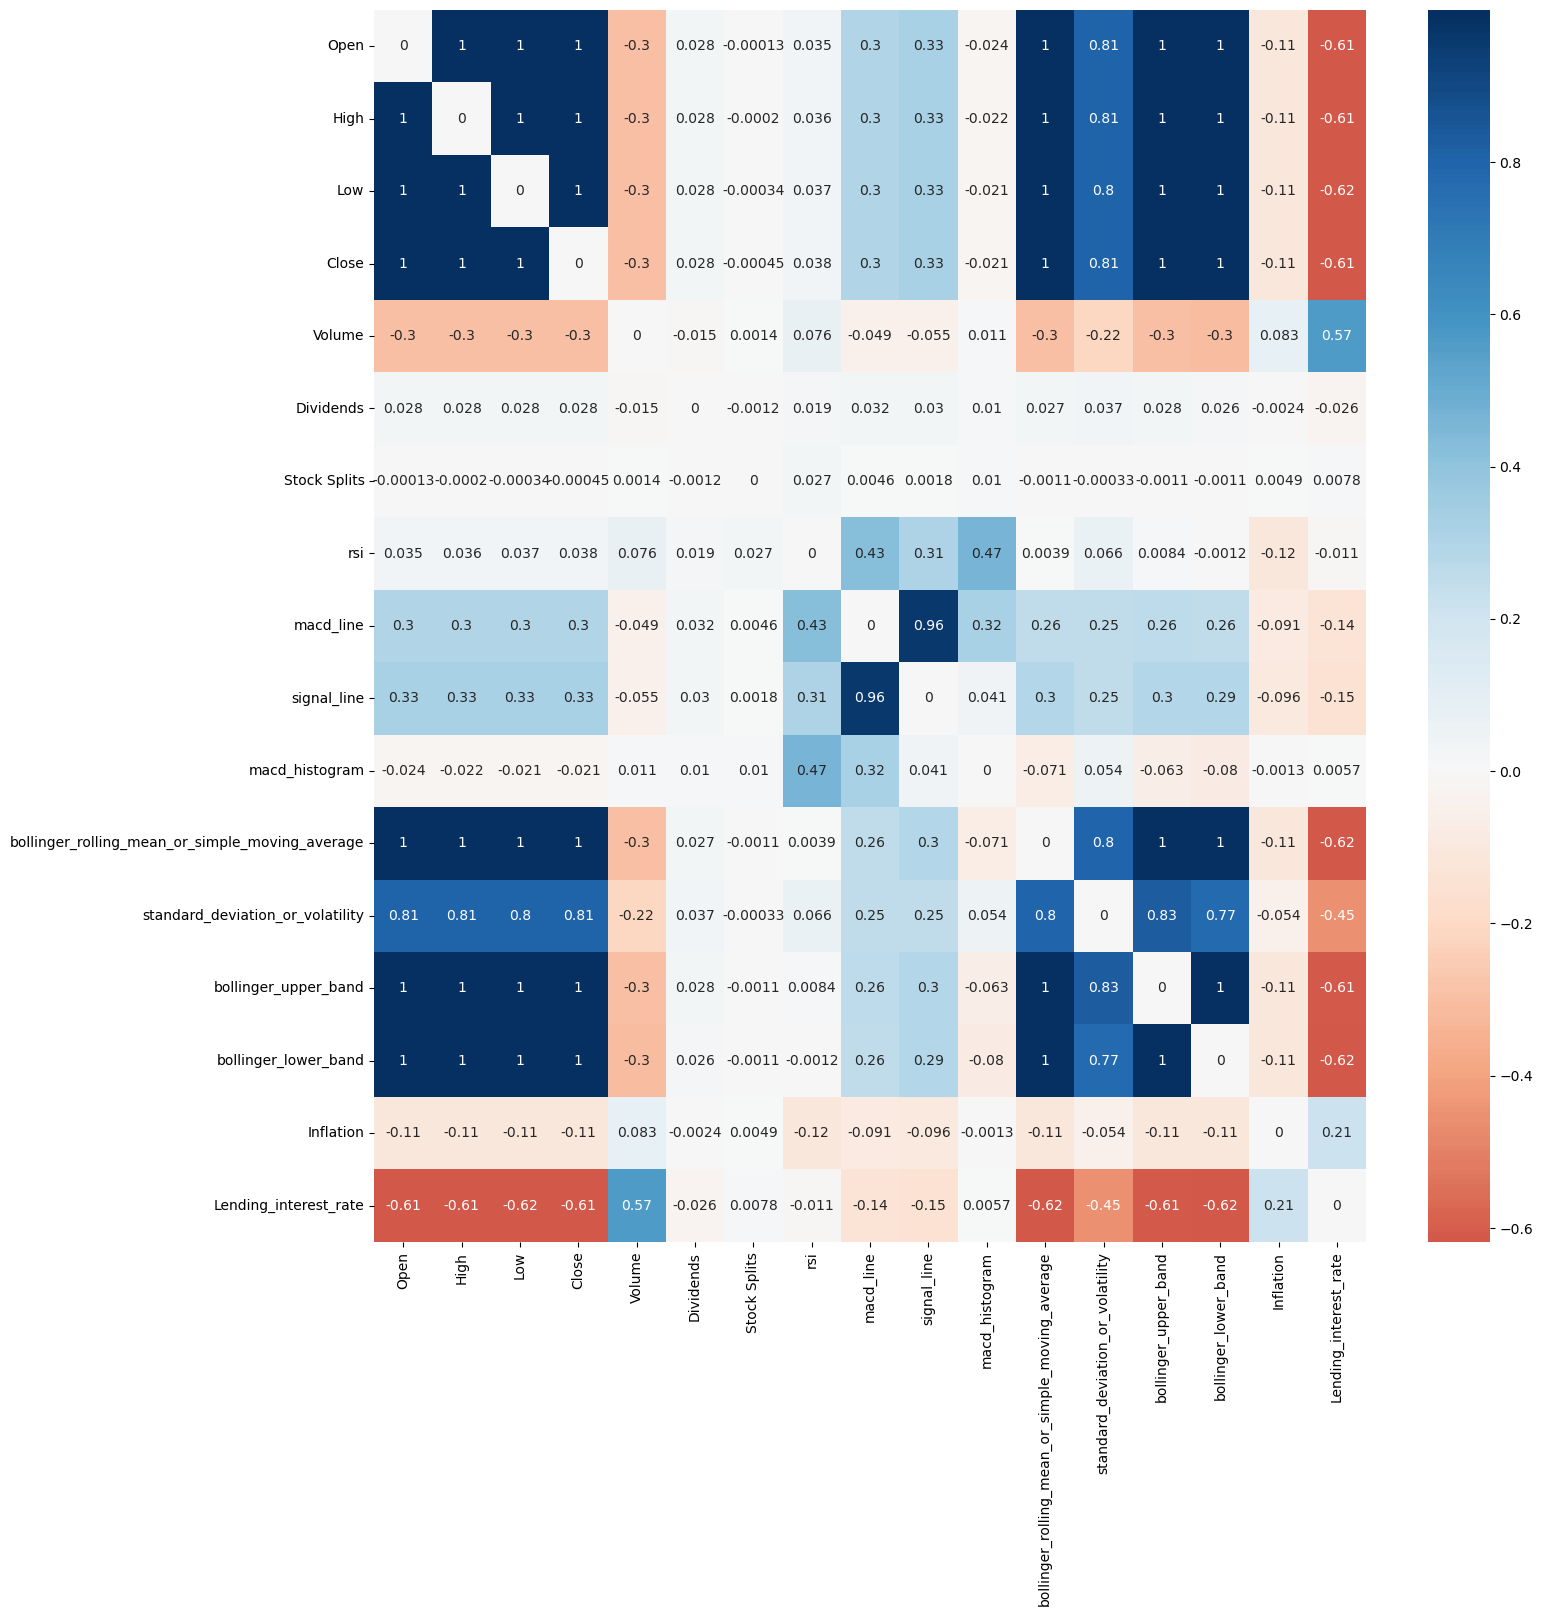

In [20]:
plt.figure(figsize = (16, 16))
sns.heatmap(corr, annot = True, cmap = 'RdBu', center = 0)
plt.show()

In [21]:
hist.describe()

Open         High          Low        Close        Volume   
count  6523.000000  6523.000000  6523.000000  6523.000000  6.523000e+03  \
mean    449.347633   454.910771   443.229147   448.806699  2.965478e+07   
std     548.050851   554.125142   541.050467   547.186404  4.894019e+07   
min       7.791653     7.827301     7.743273     7.827301  0.000000e+00   
25%      39.881207    40.533646    39.200867    39.800842  6.975051e+06   
50%     365.898695   371.552144   361.447846   366.494751  1.296180e+07   
75%     490.545274   495.433772   483.593151   489.066864  3.187741e+07   
max    2734.517166  2743.091369  2699.871396  2723.649902  6.686620e+08   

         Dividends  Stock Splits          rsi    macd_line  signal_line   
count  6523.000000   6523.000000  6523.000000  6523.000000  6523.000000  \
mean      0.013013      0.000920    52.871036     2.572397     2.589371   
std       0.242300      0.042884    17.099178    16.022656    15.183489   
min       0.000000      0.000000     1.923949  -130.143360  -111.331879   
25%       0.000000      0.000000    40.326632    -1.035016    -0.840882   
50%       0.000000      0.000000    52.353086     0.429598     0.416776   
75%       0.000000      0.000000    65.505327     4.183676     4.030107   
max       7.000000      2.000000    99.417089   119.608854   105.276508   

       macd_histogram  bollinger_rolling_mean_or_simple_moving_average   
count     6523.000000                                      6523.000000  \
mean        -0.016973                                       445.377416   
std          4.526877                                       541.969065   
min        -32.587693                                         9.053468   
25%         -0.734380                                        39.519684   
50%          0.002554                                       367.150562   
75%          0.822774                                       486.344070   
max         38.268733                                      2623.964954   

       standard_deviation_or_volatility  bollinger_upper_band   
count                       6523.000000           6523.000000  \
mean                          14.598244            474.573904   
std                           20.705152            575.725496   
min                            0.163670             10.127561   
25%                            1.473698             42.797840   
50%                            8.446538            390.582435   
75%                           17.633106            513.342138   
max                          180.293771           2768.313211   

       bollinger_lower_band    Inflation  Lending_interest_rate  
count           6523.000000  6523.000000            6523.000000  
mean             416.180927     6.484417              11.191933  
std              509.343416     2.816058               1.779594  
min                4.333835     3.328173               8.333350  
25%               36.566843     4.009436               9.672500  
50%              341.969674     5.131407              10.916667  
75%              462.637654     8.911793              12.291667  
max             2504.386303    13.230839              15.958333

In [22]:
hist.Dividends.value_counts()

Dividends
0.000000    6497
3.219483       2
0.804871       1
0.866784       1
6.500000       1
6.438965       1
5.943660       1
5.448355       1
5.200703       1
4.953050       1
4.705398       1
4.457745       1
4.210093       1
3.962440       1
3.467135       1
0.742958       1
2.724178       1
2.476525       1
1.857394       1
1.300176       1
1.238263       1
1.176349       1
1.052523       1
0.990610       1
0.928697       1
7.000000       1
Name: count, dtype: int64

In [23]:
hist['Stock Splits'].value_counts()

Stock Splits
0.0    6520
2.0       3
Name: count, dtype: int64

In [24]:
cols = hist.columns.tolist()

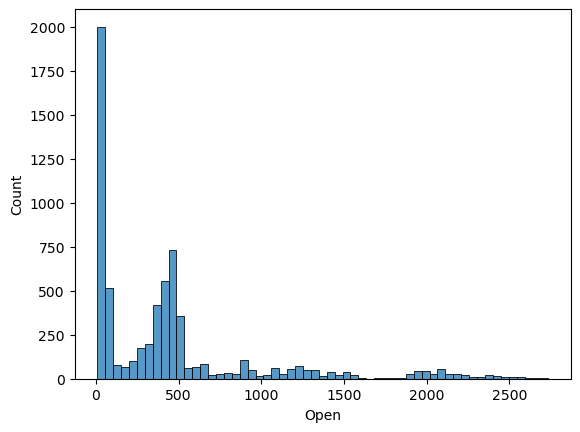

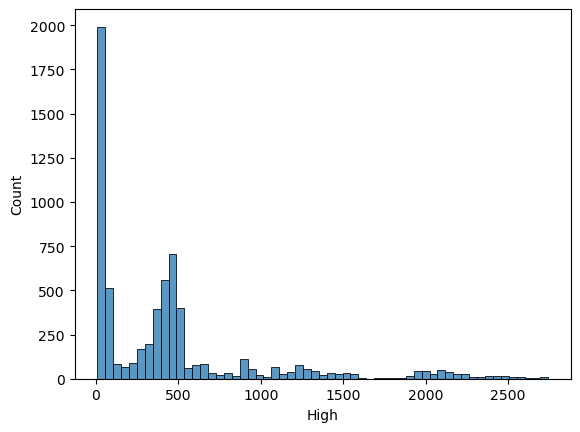

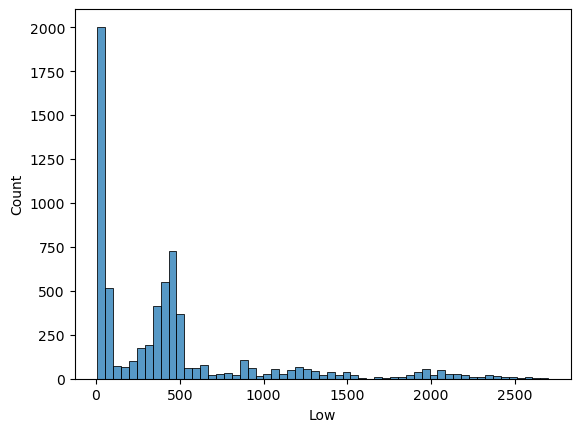

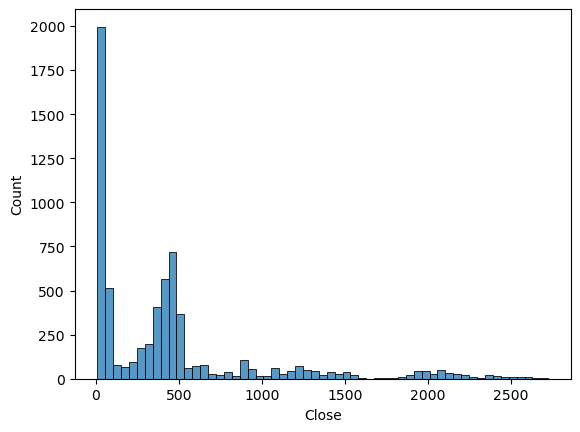

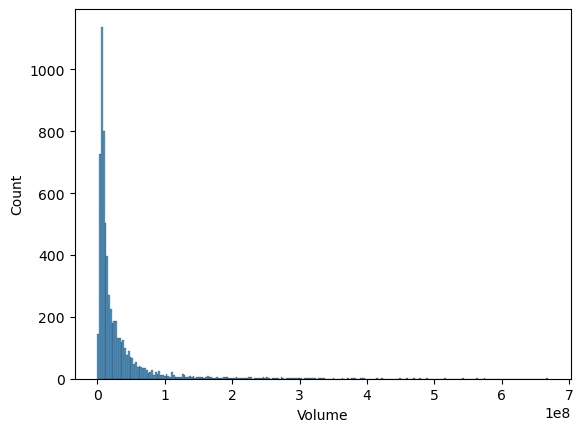

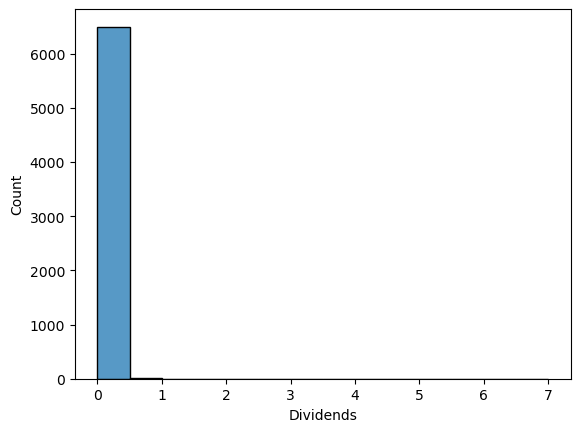

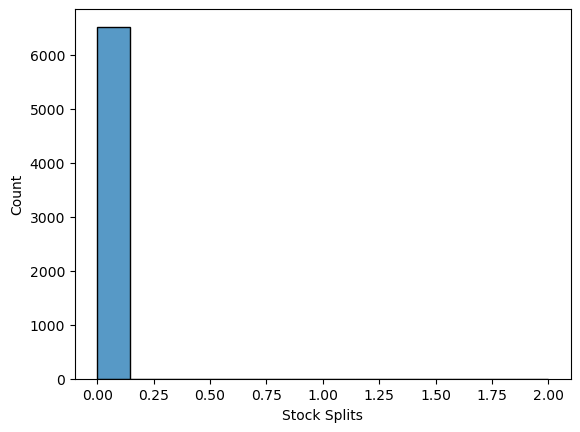

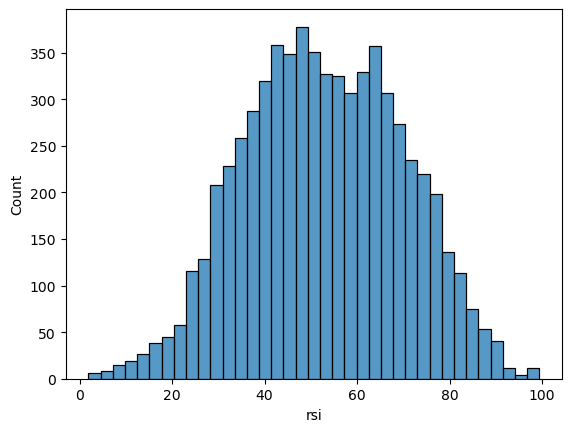

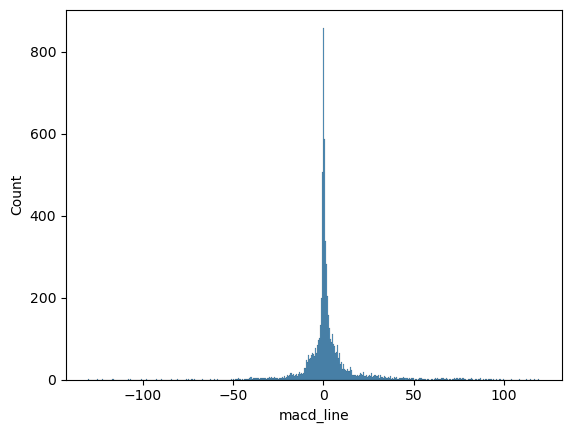

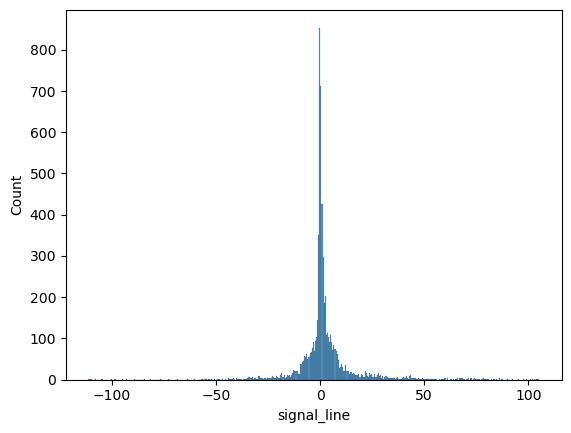

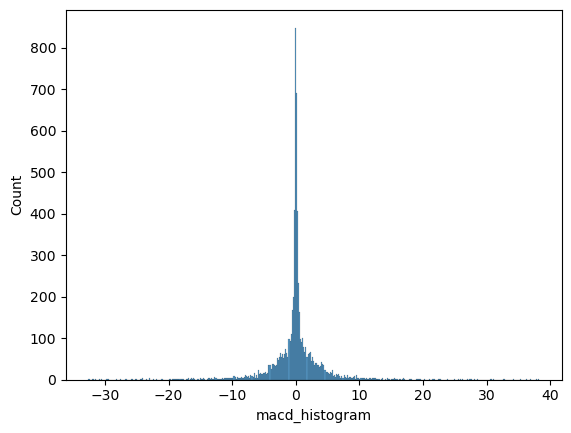

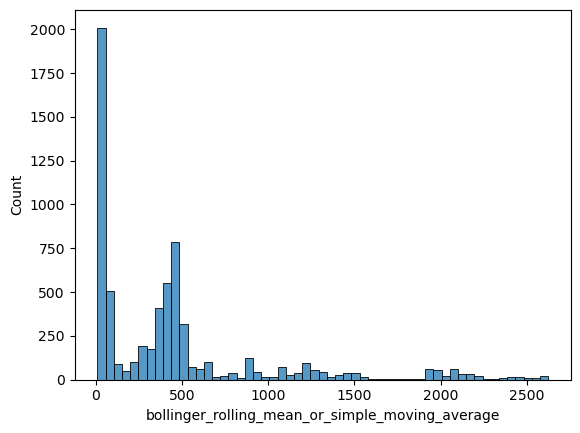

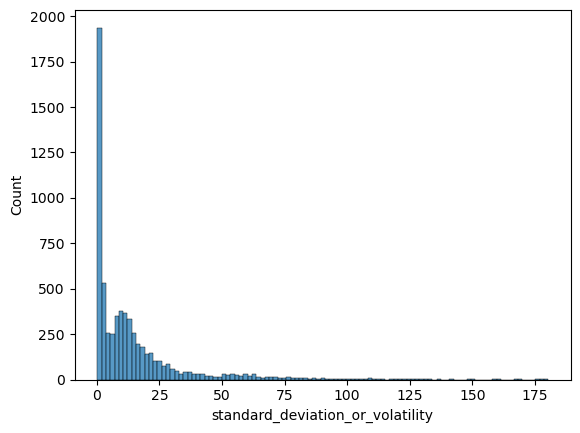

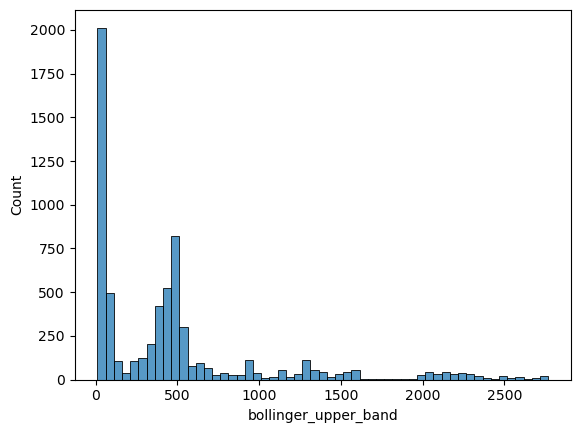

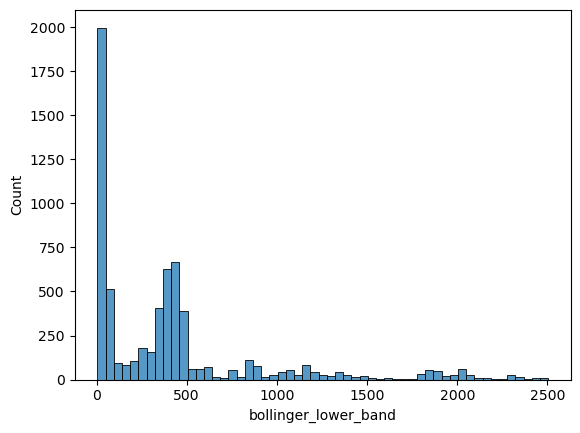

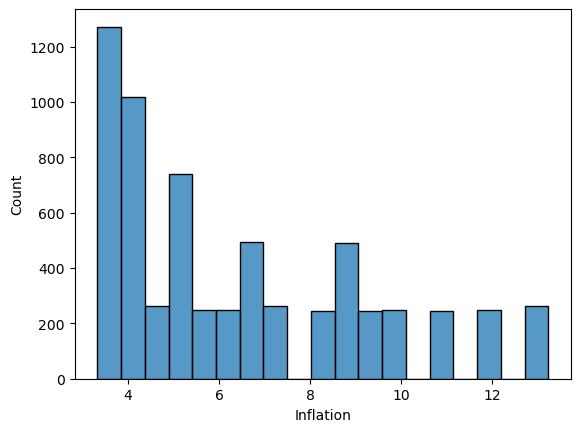

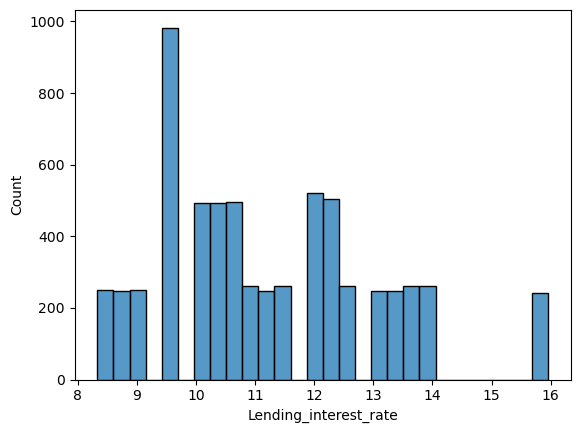

In [25]:
for col in cols:
    sns.histplot(hist, x = col)
    plt.show()

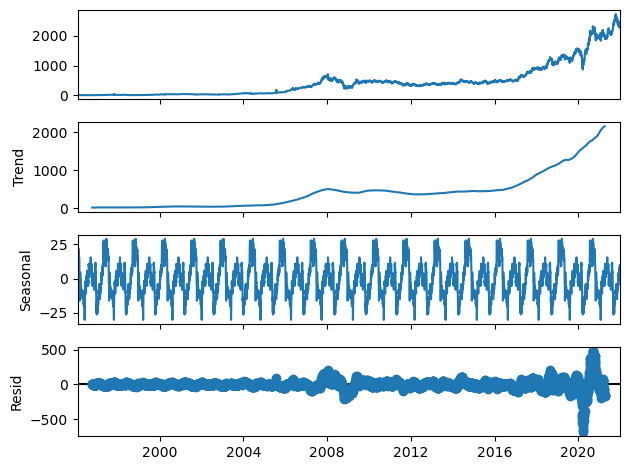

<Figure size 640x480 with 0 Axes>

In [26]:
# Getting timeseries decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(hist[['Close']], period = 365).plot()
plt.show()
plt.savefig('decompose.png')

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

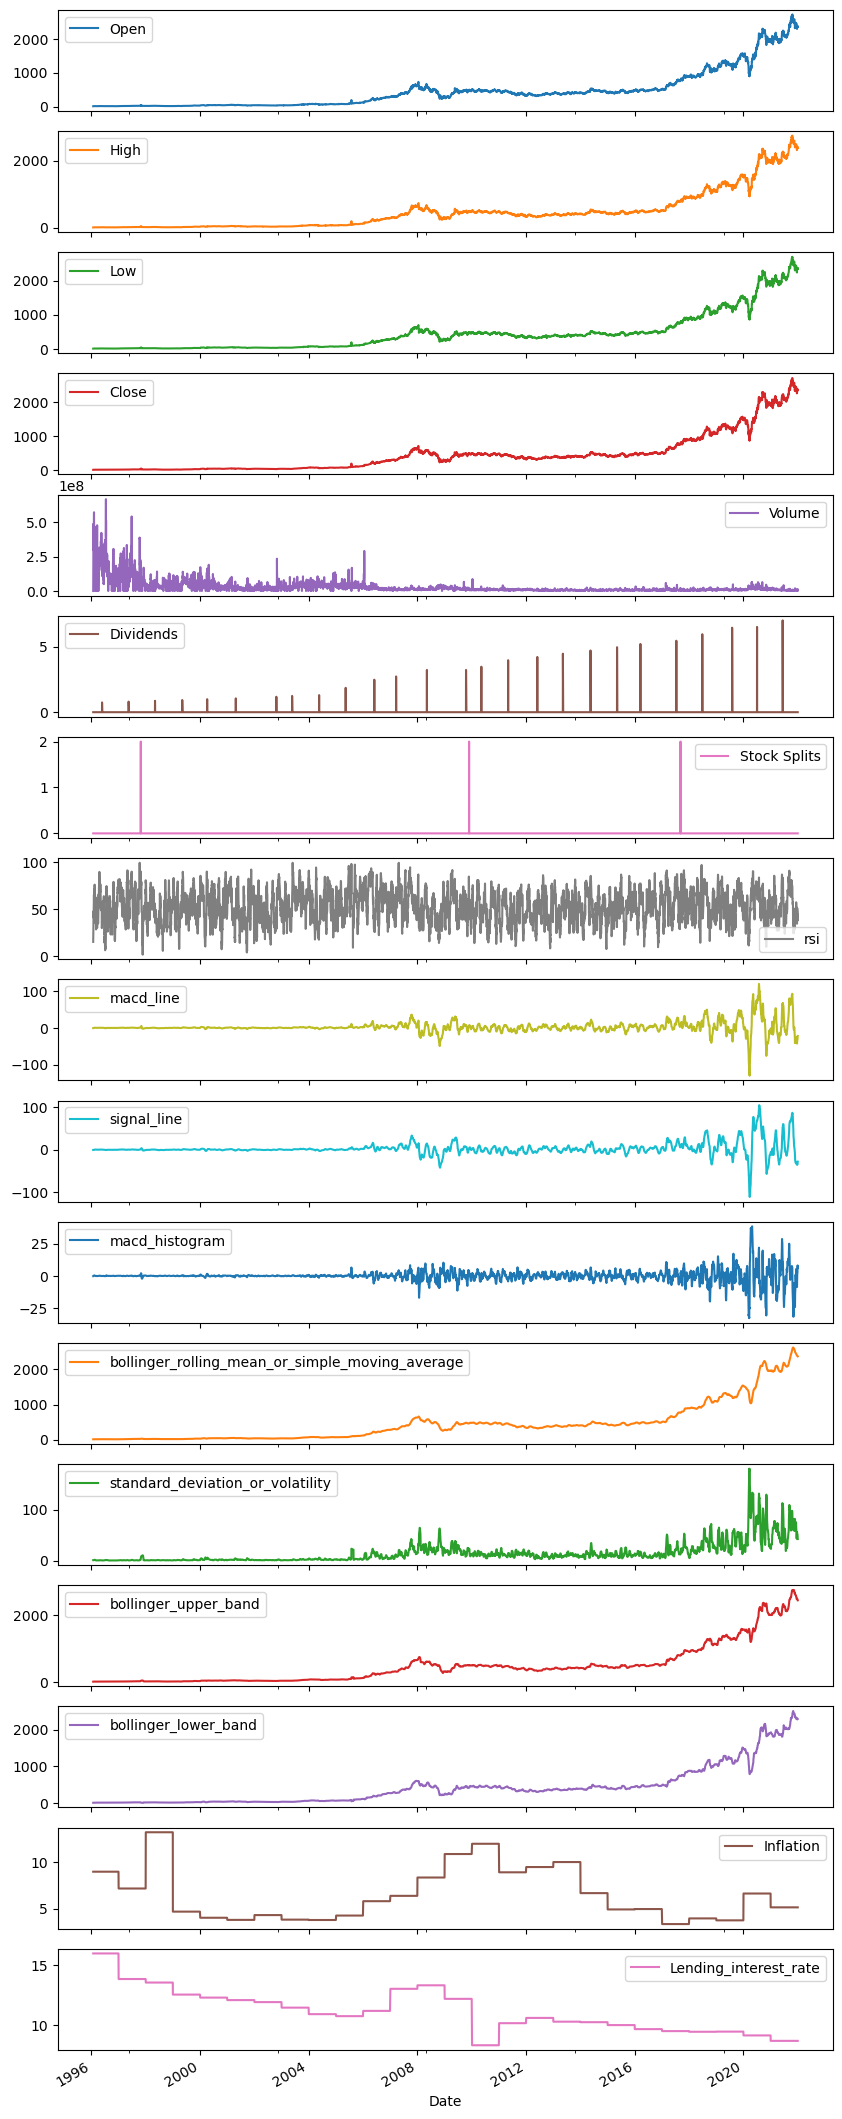

In [27]:
hist.plot(subplots = True, figsize=(10, 30))

<Axes: xlabel='Date'>

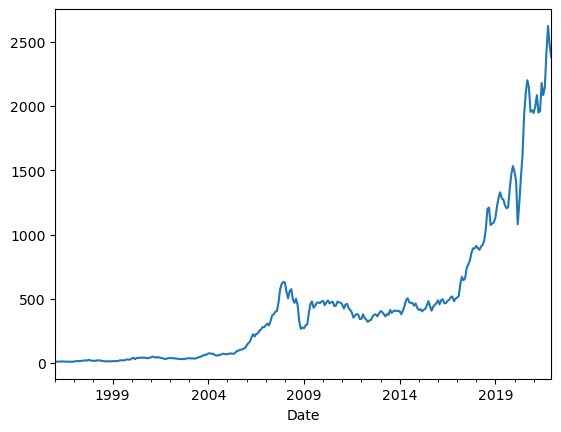

In [58]:
hist['Close'].resample('m').mean().plot()

In [72]:
hist['year']=hist.index.year
hist['month']=hist.index.month

In [75]:
hist['quarter']=hist.index.quarter
hist['dayofyear']=hist.index.dayofyear
hist['dayofweek']=hist.index.dayofweek

<Axes: xlabel='year'>

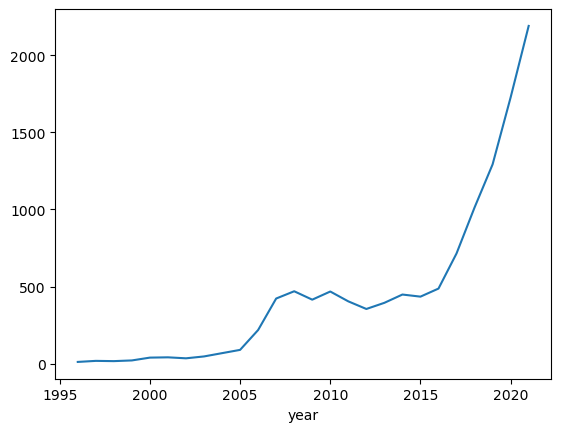

In [77]:
hist.groupby('year')['Close'].mean().plot()

In [84]:
grouped_data = hist.groupby(["dayofweek"])["Close"].mean().reset_index()

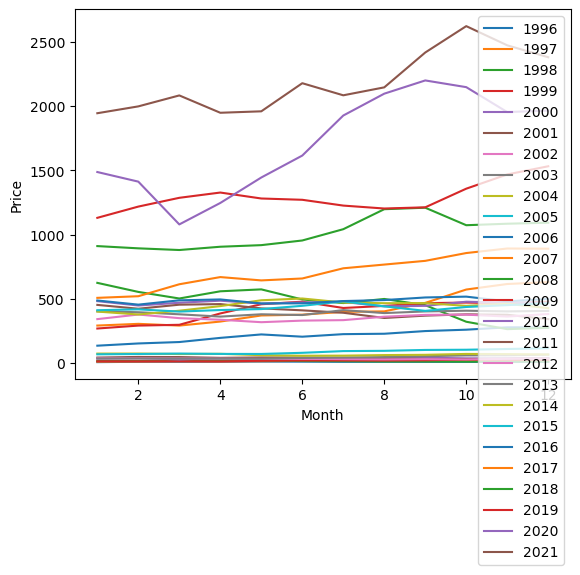

In [85]:
# Set up the figure and axis
fig, ax = plt.subplots()

# Iterate over the grouped data
for year, group in grouped_data.groupby("year"):
    # Extract the month and value for the current year
    month = group["month"]
    value = group["Close"]

    # Plot the line for the current year
    ax.plot(month, value, label=str(year))

# Add labels and legend
ax.set_xlabel("Month")
ax.set_ylabel("Price")
ax.legend()

# Show the plot
plt.show()


<Axes: xlabel='dayofweek'>

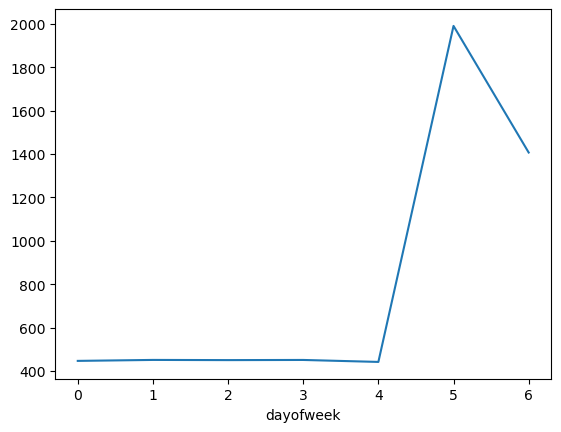

In [99]:
hist.groupby('dayofweek')['Close'].mean().plot()

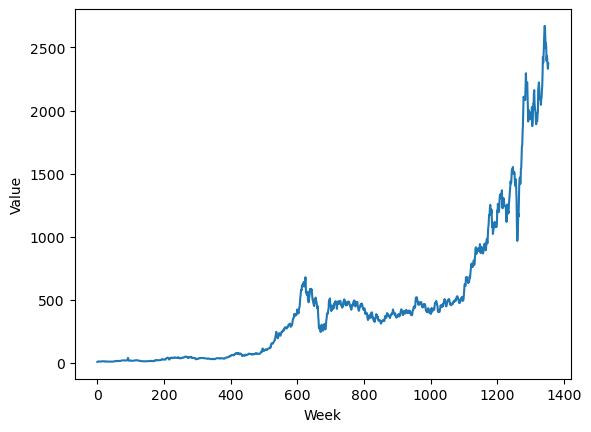

In [89]:
# Set up the figure and axis
fig, ax = plt.subplots()

# Plot the line
ax.plot(grouped_data["Close"])

# Add labels
ax.set_xlabel("Week")
ax.set_ylabel("Value")

# Show the plot
plt.show()
